In [2]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    elif model.__class__.__name__ in ("CLIPModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    else:
        raise NotImplementedError(type(model))
    # if not isinstance(layers, dict):
    #     layers = {'': layers}
    return layers

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dignal Scaled RHT Weight Block

많이 수정함

In [2]:
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)


def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)


def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = H.device
    # device = torch.device('cpu')
    (m, n) = H.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        Hr = RHT_H(Hr, SU)
        # Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    # Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

In [ ]:
import matplotlib.pyplot as plt
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf'
]

quip_hess_path = [
    './quip_hess/llama3_8b_6144',
    # './quip_hess/Hessians-Llama-2-7b-6144',
]

size_list = [
    1024,
    # 4096
]

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}
sigma_reg = 1e-4
# direction = 'col'
direction = 'row'

for model_name, size, quip_hess in zip(model_list, size_list, quip_hess_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    # datas = []
    datas = {}
    datas['weight'] = []
    datas['idx'] = []
    datas['layer_type'] = []
    datas['scale'] = []
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        for n, m in named_linears.items():
            
            W = m.weight.data.detach().to(device)
            
            if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
                H_flat = hess_dict['qkv']
            elif 'o_proj' in n:
                H_flat = hess_dict['o']
            elif 'up_proj' in n or 'gate_proj' in n:
                H_flat = hess_dict['up']
            elif 'down_proj' in n:
                H_flat = hess_dict['down']
            else:
                raise NotImplementedError(n)
            
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            n_h = H_flat['n']

            # print('before',torch.diag(H).mean())
            H = regularize_H(H, n_h, sigma_reg)
            # print('after',torch.diag(H).mean())

            ## 1
            # diagH = torch.diag(H)
            # diagW2 = torch.diag(W.T @ W)
            # diagH = torch.clamp(diagH, min=1e-8)
            # diagW2 = torch.clamp(diagW2, min=1e-8)
            # scaleWH = (diagH / diagW2).sqrt()
            # scaleWH = diagH.sqrt()
            # scaleWH = scaleWH.clamp(min=1)
            # print(scaleWH.numel())
            # print((scaleWH>=1).sum() / scaleWH.numel())
            # fig = plt.figure()
            # ax = fig.add_subplot(111)
            # ax.plot(scaleWH.cpu().numpy())
            # plt.show
            
            # (M, N) = W.shape
            # SU = (torch.randn(N).sign() + 1e-5).sign().to(device)
            # SV = (torch.randn(M).sign() + 1e-5).sign().to(device)
            # Wr = RHT_W(Wr, SU, SV)

            ## 2
            diagH = torch.diag(H)
            diagH = torch.clamp(diagH, min=1e-8)
            scaleWH = diagH.sqrt()
            Wr = W * scaleWH[None, :]
            # W_normalized = Wr / Wr.norm(p=2, dim=1, keepdim=True)
            W_normalized = Wr / Wr.std(dim=1, keepdim=True)
            Wr = W_normalized
            
            ## 4 invH
            # Lhr = torch.linalg.cholesky(H)
            # H_inv = torch.cholesky_inverse(Lhr)
            # diagH_inv = torch.diag(H_inv)
            # scaleWH = 1/diagH_inv
            # scaleWH = torch.clamp(scaleWH, min=1e-8)
            # scaleWH = scaleWH.sqrt()
            # Wr = W * scaleWH[None, :]
            # # W_normalized = Wr / Wr.norm(p=2, dim=1, keepdim=True)
            # W_normalized = Wr / Wr.std(dim=1, keepdim=True)
            # Wr = W_normalized
            
            ## 3
            # W_normalized = W / W.norm(p=2, dim=1, keepdim=True)
            # Wr = W_normalized            
            
            # print(Wr.norm(p=2, dim=1)[:10])
            
            ## 5 with col std
            col_std = Wr.std(dim=0, keepdim=True)
            col_std = col_std.expand(Wr.shape[0], Wr.shape[1])
            
            if direction == 'col':
                w = Wr.T.to('cpu')
                s = col_std.T.to('cpu')
            else:
                w = Wr.to('cpu')
                s = col_std.to('cpu')
            
            if w.shape[-1] % size == 0:
                w = w.reshape(-1, size)
                s = s.reshape(-1, size)
            else:
                raise
                D = w.shape[1]
                span = size * (D //size)
                if D < span:
                    raise ValueError("Tensor's second dimension is too small for the requested slice.")
                max_start = D - span
                start = random.randint(0, max_start)
                sliced = w[:, start : start + span]
                w = sliced.reshape(-1, size)

            # datas.append(w)

            datas['weight'].append(w)
            datas['scale'].append(s)
            
            idx = torch.tensor([i], dtype = torch.int8)
            datas['idx'].extend([idx] * w.shape[0])
            
            layer_type = torch.tensor([wtype_mapping[n]], dtype = torch.int8)
            datas['layer_type'].extend([layer_type] * w.shape[0])
    
    for k in datas.keys():
        # if datas[k][0].shape == torch.Size([]):
        #     datas[k] = torch.tensor(datas[k])
        # else:
        datas[k] = torch.cat(datas[k], dim = 0)
    
    print('total weight shape: ', datas['weight'].shape)
    
    indices = torch.randperm(len(datas['weight']))
    split_index = int(len(datas['weight']) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = {}
    dataset['val'] = {}
    for k in datas.keys():
        dataset['train'][k] = datas[k][train_indices]
        dataset['val'][k] = datas[k][val_indices]
        
    print('train: ', dataset['train']['weight'].shape, 'val: ', dataset['val']['weight'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        # mean_dim0 = data['weight'].mean(dim=0)
        # std_dim0 = data['weight'].std(dim=0)
        
        mean_all = data['weight'].mean()
        std_all = data['weight'].std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': None,
            'std_channel': None
        }
    
    # datas = torch.cat(datas, dim = 0)
    # print('total dataset shape: ', datas.shape)
    
    # indices = torch.randperm(len(datas))
    # split_index = int(len(datas) - 1000)
    # train_indices = indices[:split_index]
    # val_indices = indices[split_index:]

    # dataset = {}
    # dataset['train'] = datas[train_indices]
    # dataset['val'] = datas[val_indices]
    # print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    # dataset_stats = {}
    # for split in ['train', 'val']:
    #     data = dataset[split]
        
    #     # mean_dim0 = data.mean(dim=0)
    #     # std_dim0 = data.std(dim=0)
        
    #     mean_all = data.mean()
    #     std_all = data.std()
        
    #     dataset_stats[split] = {
    #         'mean': mean_all.item(),
    #         'std': std_all.item(),
    #         # 'mean_channel': mean_dim0.tolist(),
    #         # 'std_channel': std_dim0.tolist(),
    #         'mean_channel': None,
    #         'std_channel': None,
    #     }

    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    ## 1
    # torch.save(dataset, f'./block_pt/{model_name}/scaled3_RHT_sig{sigma_reg}_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaled3_RHT_sig{sigma_reg}_{direction}_{size}_dataset_stats.json'
    ## 2
    # torch.save(dataset, f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}_dataset_stats.json'
    ## 3
    # torch.save(dataset, f'./block_pt/{model_name}/rnormed_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/rnormed_{direction}_{size}_dataset_stats.json'
    ## 4
    # torch.save(dataset, f'./block_pt/{model_name}/scaleHinv_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaleHinv_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}_dataset_stats.json'
    ## 5
    torch.save(dataset, f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_with_col_std_lidx_{direction}_{size}.pt')
    json_path = f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_with_col_std_lidx_{direction}_{size}_dataset_stats.json'
    
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)

model_name:  meta-llama--Meta-Llama-3-8B


100%|██████████| 32/32 [01:44<00:00,  3.27s/it]


total weight shape:  torch.Size([6815744, 1024])
train:  torch.Size([6814744, 1024]) val:  torch.Size([1000, 1024])


: 

Statistics for 'scale' column:
  - Minimum value: 0.000052
  - Maximum value: 31.643507


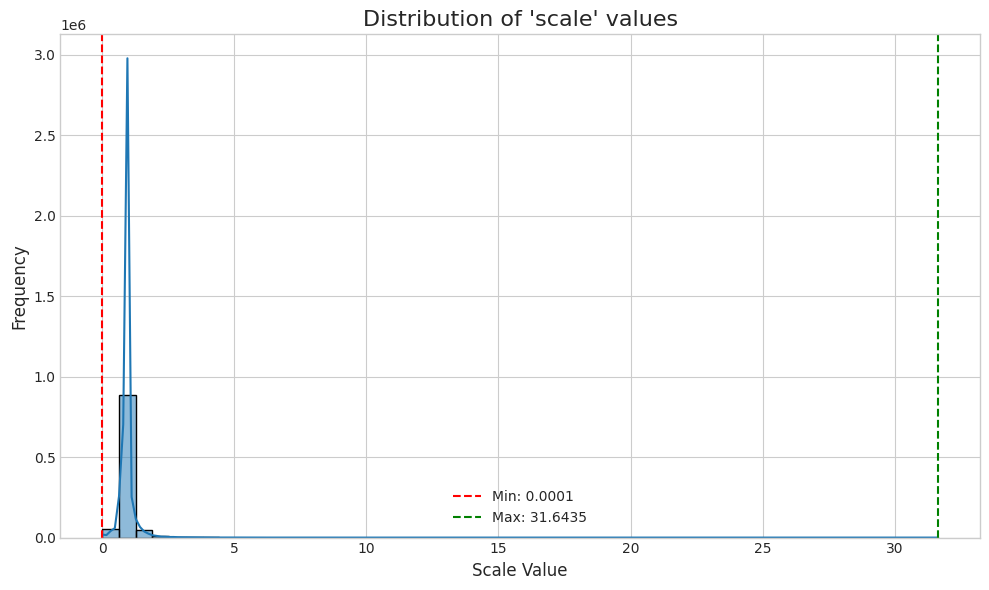

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

dataset = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/scaleH_sig0.0001_std_rnormed_with_col_std_lidx_row_1024.pt')

scale_data = np.array(dataset['train']['scale'].flatten())


WEIGHT_SAMPLE_SIZE = 1000000 # Number of weights to sample from each matrix
scale_data = np.random.choice(scale_data, WEIGHT_SAMPLE_SIZE, replace=False)

# 2. Calculate min and max values
min_val = scale_data.min()
max_val = scale_data.max()

# 3. Print the results
print(f"Statistics for 'scale' column:")
print(f"  - Minimum value: {min_val:.6f}")
print(f"  - Maximum value: {max_val:.6f}")

# 4. Plot the distribution
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Using seaborn's histplot which is great for distributions
sns.histplot(scale_data, kde=True, ax=ax, bins=50)

ax.set_title("Distribution of 'scale' values", fontsize=16)
ax.set_xlabel("Scale Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

# Add vertical lines for min and max for better visualization
ax.axvline(min_val, color='red', linestyle='--', label=f'Min: {min_val:.4f}')
ax.axvline(max_val, color='green', linestyle='--', label=f'Max: {max_val:.4f}')
ax.legend()

plt.tight_layout()
plt.show()


# Print std, mean

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt

def describe_distribution(x):
    assert isinstance(x, torch.Tensor), "Input must be a PyTorch tensor"
    x = x.flatten().float()
    n = x.numel()
    
    # 중심 경향
    mean = x.mean()
    median = x.median()

    # 산포도
    std_dev = x.std(unbiased=False)
    value_range = x.max() - x.min()
    q1 = x.kthvalue(int(0.25 * n + 1)).values
    q3 = x.kthvalue(int(0.75 * n + 1)).values
    iqr = q3 - q1

    # 모양
    skewness = ((x - mean)**3).mean() / (std_dev**3)
    kurtosis = ((x - mean)**4).mean() / (std_dev**4) - 3  # Fisher's definition

    del x
    return {
        "mean": mean.item(),
        "median": median.item(),
        "std": std_dev.item(),
        "range": value_range.item(),
        "iqr": iqr.item(),
        "skewness": skewness.item(),
        "kurtosis": kurtosis.item()
    }

model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
]


for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    # std = defaultdict(list)
    # mean = defaultdict(list)
    stats = {}
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.to('cuda:0')
            r = describe_distribution(W)
            for k,v in r.items():
                stats[f'{i}_{n}_{k}'] = v
            
    fig, ax = plt.subplots(1, len(r), figsize=(15, 3))
    
    for idx, k in enumerate(r.keys()):
        ax[idx].set_title(k)
        for n, m in named_linears.items():
            list = []
            for i in range(len(layers)):
                list.append(stats[f'{i}_{n}_{k}'])
            ax[idx].plot(list, label=n)
        # ax[idx].legend()
        ax[idx].set_xlabel('Layer')
    plt.legend()
    plt.show()
    

model_name:  meta-llama--Meta-Llama-3-8B


  0%|          | 0/32 [00:03<?, ?it/s]


KeyboardInterrupt: 

# Block with idx ltype stats
droplast

In [ ]:
model_list = [
    # 'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
#     'meta-llama--Llama-2-13b-hf',
]

size_list = [
    1024
]

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}

direction = 'col'
shuffle = False
drop_last = True

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    datas = {}
    datas['weight'] = []
    datas['idx'] = []
    datas['layer_type'] = []
    datas['mean'] = []
    datas['median'] = []
    datas['std'] = []
    datas['range'] = []
    datas['iqr'] = []
    datas['skewness'] = []
    datas['kurtosis'] = []
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            w = m.weight.data.detach()
            
            stats = describe_distribution(w)
            
            if direction == 'col':
                w = w.T

            if shuffle:
                w = w.reshape(-1, 16)  # (num_rows, 16)
                indices = torch.randperm(w.size(0))  # row 인덱스 섞기
                w = w[indices]  # 섞인 순서대로 row 재배열
                
            if drop_last:
                (r, c) = w.shape
                d = (c // size) * size
                w = w[:, :d]

            w = w.reshape(-1, size)
            
            if drop_last:
                assert w.shape[0] % r == 0
                
            # if w.size(0) % size == 0:
            #     w = w.T    
            #     w = w.reshape(-1, size)
            # else:
            #     w = w.reshape(-1, size)
                
            datas['weight'].append(w)
            
            idx = torch.tensor([i], dtype = torch.int8)
            datas['idx'].extend([idx] * w.shape[0])
            
            layer_type = torch.tensor([wtype_mapping[n]], dtype = torch.int8)
            datas['layer_type'].extend([layer_type] * w.shape[0])
            
            for k, v in stats.items():
                val_tensor = torch.tensor([v], dtype=torch.float32)
                datas[k].extend([val_tensor] * w.shape[0])
    
    for k in datas.keys():
        # if datas[k][0].shape == torch.Size([]):
        #     datas[k] = torch.tensor(datas[k])
        # else:
        datas[k] = torch.cat(datas[k], dim = 0)
    
    print('total weight shape: ', datas['weight'].shape)
    
    indices = torch.randperm(len(datas['weight']))
    split_index = int(len(datas['weight']) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = {}
    dataset['val'] = {}
    for k in datas.keys():
        dataset['train'][k] = datas[k][train_indices]
        dataset['val'][k] = datas[k][val_indices]
        
    print('train: ', dataset['train']['weight'].shape, 'val: ', dataset['val']['weight'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        mean_dim0 = data['weight'].mean(dim=0)
        std_dim0 = data['weight'].std(dim=0)
        
        mean_all = data['weight'].mean()
        std_all = data['weight'].std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': mean_dim0.tolist(),
            'std_channel': std_dim0.tolist(),
        }

    # os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_layerwise_stats.pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_layerwise_stats_dataset_stats.json'
    # with open(json_path, 'w') as f:
    #     json.dump(dataset_stats, f)
        
    sub = ''
    if shuffle:
        sub += 'shuffled_'
    if drop_last:
        sub += 'droplast_'
    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{sub}{direction}_{size}_idx_ltype_stats.pt')
    json_path = f'./block_pt/{model_name}/{sub}{direction}_{size}_idx_ltype_stats_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)

model_name:  meta-llama--Llama-2-7b-hf


100%|██████████| 32/32 [06:46<00:00, 12.72s/it]


total weight shape:  torch.Size([6127616, 1024])
train:  torch.Size([6126616, 1024]) val:  torch.Size([1000, 1024])


: 

# print shape

In [2]:
# 행렬 크기 설정 (예: 5x3 행렬)
rows, cols = 1000, 3

# 열별 평균과 표준편차 정의
mean = torch.tensor([0.0, 2.0, -1.0])  # 열별 평균값
std = torch.tensor([1.0, 0.5, 2.0])    # 열별 표준편차

# 가우시안 랜덤 행렬 생성 (브로드캐스팅 활용)
random_matrix = torch.normal(mean.expand(rows, cols), std.expand(rows, cols))

print(random_matrix)
print(random_matrix.mean(0))
print(random_matrix.std(0))

tensor([[-0.5469,  2.6361, -0.1016],
        [ 1.1328,  2.3082,  2.6023],
        [ 0.4617,  1.7054, -1.7808],
        ...,
        [-0.0045,  1.9968,  1.9926],
        [ 0.7723,  2.4261, -2.2338],
        [ 1.5540,  3.0081, -0.6574]])
tensor([-0.0077,  2.0123, -0.9304])
tensor([1.0347, 0.5134, 2.0589])


In [3]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
    # 'openai/clip-vit-large-patch14',
    
]

size_list = [
    1024,
    4096,
    # 5120//4,
]

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    # model = AutoModel.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)[0:1]

    if not isinstance(layers, dict):
        layers = {'': layers}

    for k, v in layers.items():
        print(k)
        named_linears = get_named_linears(v)
        for n, m in named_linears.items():
            print(n, m.weight.data.shape)
            W = m.weight.data
            r, c = W.shape

        # mean_c = W.mean(0)
        # std_c = W.std(0)
        # if r % size != 0:
        #     padding_size = size - r % size
        #     g = torch.normal(mean_c.expand(padding_size, c), std_c.expand(padding_size, c))
        #     W = torch.cat([W, g], dim=0)
        #     print('padding')
        #     print(n, W.shape)
        #     print(mean_c[:5], std_c[:5])
        #     print(W.mean(0)[:5], W.std(0)[:5])
        

model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00, 10.00it/s]



0.self_attn.q_proj torch.Size([4096, 4096])
0.self_attn.k_proj torch.Size([1024, 4096])
0.self_attn.v_proj torch.Size([1024, 4096])
0.self_attn.o_proj torch.Size([4096, 4096])
0.mlp.gate_proj torch.Size([14336, 4096])
0.mlp.up_proj torch.Size([14336, 4096])
0.mlp.down_proj torch.Size([4096, 14336])
model_name:  meta-llama--Llama-2-7b-hf


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  9.51it/s]


0.self_attn.q_proj torch.Size([4096, 4096])
0.self_attn.k_proj torch.Size([4096, 4096])
0.self_attn.v_proj torch.Size([4096, 4096])
0.self_attn.o_proj torch.Size([4096, 4096])
0.mlp.gate_proj torch.Size([11008, 4096])
0.mlp.up_proj torch.Size([11008, 4096])
0.mlp.down_proj torch.Size([4096, 11008])


# Block
### layerwise suffle
레이어 안에서 16 block으로 섞음
### drop last
### 8b + 7b

In [6]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
    # 'openai--clip-vit-large-patch14',
]

size_list = [
    1024,
    1024,
    # 4096,
    # 256,
]

direction = 'col'
shuffle = False
drop_last = True
modelwise_norm = True

model_datas = []
for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    # model = AutoModel.from_pretrained(model_path, local_files_only=True)
    # layers_ = get_blocks(model)    
    layers = get_blocks(model)    

    # datas = []    
    # for sub in layers_:
        # layers = layers_[sub]
    # if sub == 'vision':
    #     size = 1024
    # elif sub == 'text':
    #     size = 768
    # else:
    #     raise
    
    datas = []
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            w = m.weight.data.detach()
            
            # if w.size(0) % size == 0:
            #     w = w.T    
            #     w = w.reshape(-1, size)
            # else:
            #     w = w.reshape(-1, size)
            
            if direction == 'col':
                w = w.T

            if shuffle:
                w = w.reshape(-1, 16)  # (num_rows, 16)
                indices = torch.randperm(w.size(0))  # row 인덱스 섞기
                w = w[indices]  # 섞인 순서대로 row 재배열
                
            if drop_last:
                (r, c) = w.shape
                d = (c // size) * size
                w = w[:, :d]

            w = w.reshape(-1, size)
            
            if drop_last:
                assert w.shape[0] % r == 0

            datas.append(w)
        
    datas = torch.cat(datas, dim = 0)
    if modelwise_norm:
        mu = datas.mean()
        std = datas.std()
        datas = (datas - mu) / std
        
    model_datas.append(datas)
    
model_name = 'llama8b+7b'
model_datas = torch.cat(model_datas, dim = 0)
print('total dataset shape: ', model_datas.shape)
datas = model_datas

indices = torch.randperm(len(datas))
split_index = int(len(datas) - 1000)
train_indices = indices[:split_index]
val_indices = indices[split_index:]

dataset = {}
dataset['train'] = datas[train_indices]
dataset['val'] = datas[val_indices]
print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

dataset_stats = {}
for split in ['train', 'val']:
    data = dataset[split]
    
    dataset_stats[split] = {
        'mean': data.mean().item(),
        'std': data.std().item(),
        # 'mean_channel': data.mean(dim=0).tolist(),
        # 'std_channel': data.std(dim=0).tolist(),
    }

# if sub != '':
#     sub = sub+ '_'
# sub = 'vision_text_'
sub = ''
if shuffle:
    sub += 'shuffled_'
if drop_last:
    sub += 'droplast_'
if modelwise_norm:
    sub += 'modelwise_norm2_'
os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
torch.save(dataset, f'./block_pt/{model_name}/{sub}{direction}_{size}.pt')
json_path = f'./block_pt/{model_name}/{sub}{direction}_{size}_dataset_stats.json'
with open(json_path, 'w') as f:
    json.dump(dataset_stats, f)

model_name:  meta-llama--Meta-Llama-3-8B


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


model_name:  meta-llama--Llama-2-7b-hf


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


total dataset shape:  torch.Size([12943360, 1024])
train:  torch.Size([12942360, 1024]) val:  torch.Size([1000, 1024])


## gaussian block

In [5]:
d = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/col_1024_gaussian_padding.pt')
print(d['train'].shape)
print(d['val'].shape)

torch.Size([6814744, 1024])
torch.Size([1000, 1024])


In [6]:
dataset = {}
dataset['train'] = torch.normal(mean=0.0, std=1.0, size=d['train'].shape)
dataset['val'] = torch.normal(mean=0.0, std=1.0, size=d['val'].shape)


In [7]:
print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

dataset_stats = {}
for split in ['train', 'val']:
    data = dataset[split]
    
    mean_all = data.mean()
    std_all = data.std()
    
    dataset_stats[split] = {
        'mean': mean_all.item(),
        'std': std_all.item(),
    }

sub = 'llama8b_'
direction = 'col'
size = 1024
os.makedirs(f'./block_pt/gaussian', exist_ok = True)
torch.save(dataset, f'./block_pt/gaussian/{sub}{direction}_{size}.pt')
json_path = f'./block_pt/gaussian/{sub}{direction}_{size}_dataset_stats.json'
with open(json_path, 'w') as f:
    json.dump(dataset_stats, f)

train:  torch.Size([6814744, 1024]) val:  torch.Size([1000, 1024])


# layerwise, channelwise normalized Block

In [2]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
    # 'openai--clip-vit-large-patch14',
]

size_list = [
    1024,
    # 4096,
    # 4096,
    # 256,
]

# direction = 'adapt'
direction = 'col'

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    # model = AutoModel.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

        
    datas = []
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.detach().cuda()

            W = (W - W.mean(dim=0, keepdim=True)) / W.std(dim=0, keepdim=True)
            # W = (W - W.mean()) / W.std()
            
            if direction == 'col':
                W = W.T    
            W = W.reshape(-1, size).cpu()
                
            datas.append(W)
        
    datas = torch.cat(datas, dim = 0)
    print('total dataset shape: ', datas.shape)
    
    indices = torch.randperm(len(datas))
    split_index = int(len(datas) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = datas[train_indices]
    dataset['val'] = datas[val_indices]
    print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        # mean_dim0 = data.mean(dim=0)
        # std_dim0 = data.std(dim=0)        
        # mean_all = data.mean()
        # std_all = data.std()
        
        # dataset_stats[split] = {
        #     'mean': mean_all.item(),
        #     'std': std_all.item(),
        #     'mean_channel': mean_dim0.tolist(),
        #     'std_channel': std_dim0.tolist(),
        # }
        dataset_stats[split] = {
            'mean': 0,
            'std': 1,
            'mean_channel': None,
            'std_channel': None,
        }
        


    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_colwise_normed.pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_colwise_normed_dataset_stats.json'
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_layerwise_normed.pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_layerwise_normed_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)

model_name:  meta-llama--Meta-Llama-3-8B


100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


total dataset shape:  torch.Size([6815744, 1024])
train:  torch.Size([6814744, 1024]) val:  torch.Size([1000, 1024])


In [11]:
layers

{'': ModuleList(
   (0-31): 32 x LlamaDecoderLayer(
     (self_attn): LlamaAttention(
       (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
       (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
       (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
       (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
     )
     (mlp): LlamaMLP(
       (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
       (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
       (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
       (act_fn): SiLU()
     )
     (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
     (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
   )
 )}

# gaussian padding

size가 안 맞으면 같은 row 나 col의 mean, std를 갖는 가우시안으로 padding

In [ ]:
model_list = [
    # 'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    'meta-llama--Llama-2-13b-hf',
]

size_list = [
    # 1024,
    1024,
    1280,
]

# direction = 'adapt'
direction = 'col'

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    datas = []
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.detach()

            r, c = W.shape

            if direction == 'col':
                if r % size != 0:
                    padding_size = size - r % size
                    mean_c = W.mean(0)
                    std_c = W.std(0)

                    g = torch.normal(mean_c.expand(padding_size, c), std_c.expand(padding_size, c))
                    W = torch.cat([W, g], dim=0)
            elif direction =='row':
                raise NotImplementedError
            else:
                raise KeyError
            
            if direction == 'col':
                W = W.T
            
            assert W.shape[1] % size == 0
            assert W.shape[1] >= size

            W = W.reshape(-1, size)
                
            datas.append(W)
    
    datas = torch.cat(datas, dim = 0)
    print('total dataset shape: ', datas.shape)
    
    indices = torch.randperm(len(datas))
    split_index = int(len(datas) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = datas[train_indices]
    dataset['val'] = datas[val_indices]
    print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        mean_dim0 = data.mean(dim=0)
        std_dim0 = data.std(dim=0)
        
        mean_all = data.mean()
        std_all = data.std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': mean_dim0.tolist(),
            'std_channel': std_dim0.tolist(),
        }

    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_gaussian_padding.pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_gaussian_padding_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)

# RHT smoothed Weight Block

In [ ]:
import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)


def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)


def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = W.device
    # device = torch.device('cpu')
    (m, n) = W.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        # Hr = RHT_H(Hr, SU)
        Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
]

size_list = [
    4096,
    # 4096,
    # 4096,
]

# direction = 'adapt'
direction = 'col'

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    datas = []
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            w = m.weight.data.detach()
            
            Lhr, H, w, SU, SV, scaleWH = incoherence_preprocess(None, w, None) 
            
            if direction == 'col':
                w = w.T
            
            # if w.size(0) % size == 0:
            #     w = w.T    
            #     w = w.reshape(-1, size)
            # else:
            #     w = w.reshape(-1, size)
                
            w = w.reshape(-1, size)
            
            datas.append(w)
    
    datas = torch.cat(datas, dim = 0)
    print('total dataset shape: ', datas.shape)
    
    indices = torch.randperm(len(datas))
    split_index = int(len(datas) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = datas[train_indices]
    dataset['val'] = datas[val_indices]
    print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        mean_dim0 = data.mean(dim=0)
        std_dim0 = data.std(dim=0)
        
        mean_all = data.mean()
        std_all = data.std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': mean_dim0.tolist(),
            'std_channel': std_dim0.tolist(),
        }

    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_RHT.pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_RHT_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)